In [1]:
from PIL import Image, ImageDraw
from io import BytesIO
import json
import joblib
import os
import requests
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import feature as skif

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

random.seed(25)

MOCO_MODEL = './moco_v2_800ep_pretrain.pth'
DATA_PATH = '/data4/imagenet/ILSVRC/Data/CLS-LOC/train/'
MOCO_FEATURE_PATH = './features_moco/{}.torch'

In [2]:
def load_moco_parameters(checkpoint):
    check_state_dict = {}
    for key, val in checkpoint['state_dict'].items():
        if key.startswith('module.encoder_q.fc.2'):
            continue
        elif key.startswith('module.encoder_q.fc.0'):
            check_state_dict['fc.'+key.split('.')[-1]] = val
        elif key.startswith('module.encoder_q.'):
            check_state_dict[key[17:]] = val
        else:
            print(key)
            check_state_dict[key] = val
    return check_state_dict

In [3]:
# Data loader
class ImageNetSolo(Dataset):
    def __init__(self, index, data_path):
        super(ImageNetSolo, self).__init__()
        categories = os.listdir(data_path)
        names = os.listdir(os.path.join(data_path, categories[index]))
        self.category = categories[index]
        self.images = [os.path.join(DATA_PATH, categories[index], name) for name in names]
        self.transform = transforms.Compose([
                            transforms.Resize(260),
                            transforms.CenterCrop(256),
                            transforms.ToTensor(),])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        path = self.images[index]
        with open(path, 'rb') as f:
            sample = Image.open(f).convert('RGB')
            sample = self.transform(sample)
        return sample, index
    
def get_loader(index, batch_size=256):
    dataset = ImageNetSolo(index, DATA_PATH)
    loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)
    return loader, dataset

In [4]:
def get_outputs(model, index):
    # show reconstructed image
    indexes = []
    features = []
    out_paths = []
    model.eval()
    val_loader, val_data = get_loader(index=index, batch_size=32)
    img_paths = val_data.images
    category = val_data.category
    
    with torch.no_grad():
        for images, ids in val_loader:
            images = images.cuda()
            z = model(images)
            indexes.append(ids.view(-1).cpu())
            features.append(z.cpu())
        indexes = torch.cat(indexes, dim=0).numpy()
        features = torch.cat(features, dim=0).numpy()
    
    for idx in list(indexes):
        out_paths.append(img_paths[idx])
    return features, out_paths, category

In [5]:
def get_cluster_label(features, category, out_paths, output_dict, NUM_CLUSTER=6):
    output_dict[category] = {}
    kmeans = KMeans(n_clusters=NUM_CLUSTER).fit(features)
    for path, label in zip(out_paths, list(kmeans.labels_)):
        if label in output_dict[category]:
            output_dict[category][label].append(path)
        else:
            output_dict[category][label] = [path,]
    return output_dict

In [6]:
def displays_image_list(path_dict, print_number=5, num_per_line=15):
    plt.figure(figsize=(num_per_line*2,print_number*2))
    for k in range(print_number):
        lines = print_number
        for j in range(num_per_line):
            idx = k * num_per_line + j
            idx_plot = idx
            img_temp = Image.open(path_dict[k][j]).resize((64,64))
            #Image.fromarray(np.uint8((org_img[intra_label[k][j]])*255))
            ax = plt.subplot(lines, num_per_line, idx_plot+1)##控制plot位置
            plt.imshow(img_temp)

In [7]:
# load moco model
checkpoint = torch.load(MOCO_MODEL)
check_state_dict = load_moco_parameters(checkpoint)
model = torchvision.models.resnet50(num_classes=2048).cuda()
model.load_state_dict(check_state_dict)

<All keys matched successfully>

In [8]:
output_dict = {}
NUM_CLUSTER = 6
for index in range(len(os.listdir(DATA_PATH))):
    print('======== Leanring {} category ==========='.format(index))
    features, out_paths, category = get_outputs(model, index)
    output_dict = get_cluster_label(features, category, out_paths, output_dict, NUM_CLUSTER=NUM_CLUSTER)
    # save features and image paths
    torch.save({'features':features, 'paths':out_paths}, MOCO_FEATURE_PATH.format(category))
torch.save(output_dict, MOCO_FEATURE_PATH.format('clustering_outputs'))

======== Leanring 0 category ===========
======== Leanring 1 category ===========
======== Leanring 2 category ===========
======== Leanring 3 category ===========
======== Leanring 4 category ===========
======== Leanring 5 category ===========
======== Leanring 6 category ===========
======== Leanring 7 category ===========
======== Leanring 8 category ===========
======== Leanring 9 category ===========
======== Leanring 10 category ===========
======== Leanring 11 category ===========
======== Leanring 12 category ===========
======== Leanring 13 category ===========
======== Leanring 14 category ===========
======== Leanring 15 category ===========
======== Leanring 16 category ===========
======== Leanring 17 category ===========
======== Leanring 18 category ===========
======== Leanring 19 category ===========
======== Leanring 20 category ===========
======== Leanring 21 category ===========
======== Leanring 22 category ===========
======== Leanring 23 category ===========
==

/home/kaihua/anaconda3/envs/long-tail/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:785: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


======== Leanring 180 category ===========
======== Leanring 181 category ===========
======== Leanring 182 category ===========
======== Leanring 183 category ===========
======== Leanring 184 category ===========
======== Leanring 185 category ===========
======== Leanring 186 category ===========
======== Leanring 187 category ===========
======== Leanring 188 category ===========
======== Leanring 189 category ===========
======== Leanring 190 category ===========
======== Leanring 191 category ===========
======== Leanring 192 category ===========
======== Leanring 193 category ===========
======== Leanring 194 category ===========
======== Leanring 195 category ===========
======== Leanring 196 category ===========
======== Leanring 197 category ===========
======== Leanring 198 category ===========
======== Leanring 199 category ===========
======== Leanring 200 category ===========
======== Leanring 201 category ===========
======== Leanring 202 category ===========
======== Le

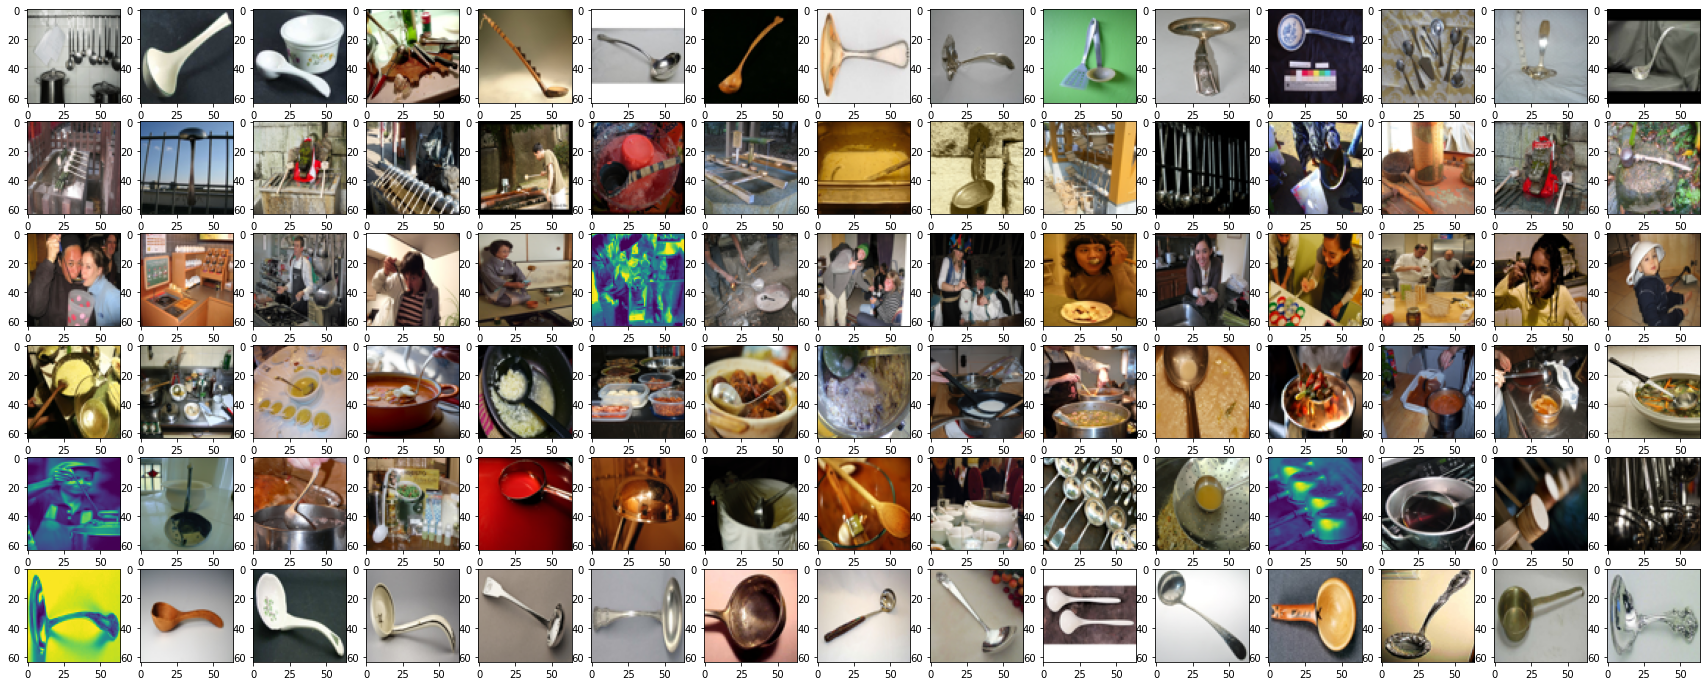

In [13]:
# visualize results
index = 2
category = list(output_dict.keys())[index]
displays_image_list(output_dict[category], print_number=NUM_CLUSTER, num_per_line=15)